# Explain our XGBoost model

The goal of this notebook is to interpret our XGBoost model. A good understanding of how the predictions are made could lead to interesting business insights. 

good reading: [Interpretable Machine Learning with XGBoost](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)


In [1]:
import pickle
import numpy as np
import pandas as pd
import shap

from xgboost import XGBRegressor

shap.initjs()

/home/guillaume/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Explanation of the original model

In [2]:
# load the preprocessed dataset (training data)
X = pd.read_csv('data/train_preprocessed.csv')

# remove the logarithm on the sales to deal with the true value (more understandable)
y = np.exp(X['Sales'])

# drop the target
X.drop(columns=['Sales', 'Customers'], inplace=True)

# fit the model 
model = XGBRegressor(objective='reg:linear')
model.fit(X.values, y.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [3]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Explain the  model's prediction for individual samples

In [4]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [5]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [6]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X.iloc[3,:])

### Explain the model's predictions on the entire dataset

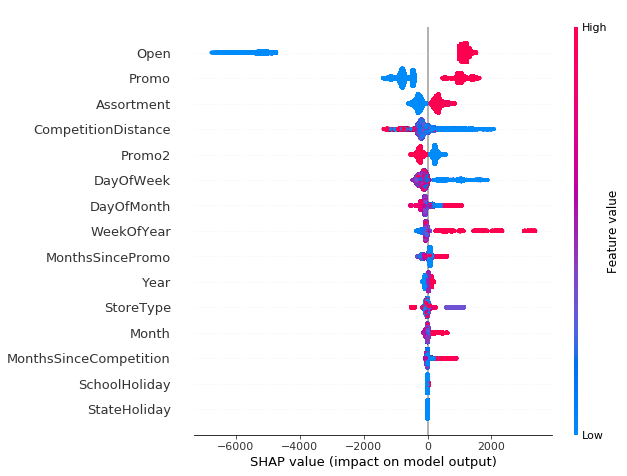

In [7]:
shap.summary_plot(shap_values, X)

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature (such as `Promo`) on a row, where the x-axis is the SHAP value, which encode the impact on the `Sales` (output of the model). By doing this for all features, we see which features drive the model's prediction a lot (such as `Open`), and which only effect the prediction a little (such as `SchoolHoliday`). Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

([source](https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html#Summarize-the-impact-of-all-features-over-the-entire-dataset))

## Retrain the model without the feature `Open` 

In our model, the importance of the feature `Open` is much higher than the one of the other features. It makes perfect sense because when a shop is closed, they are no sales. It is therefore the best discrimination.  

Because of that, it is hard to visualize the importance of the other features, which could provide more interesting business insights.

Here, we remove the samples where the shops are closed and we remove the column `Open`. Then we fit the new XGBoost model. 

In [8]:
X = pd.read_csv('data/train_preprocessed.csv')

# keep only the samples where the shops are open
X = X.loc[X['Open'] == 1]
y = np.exp(X['Sales'])

# remove the feature "Open" and the target
X.drop(columns=['Open', 'Sales', 'Customers'], inplace=True)

# fit the new model
model = XGBRegressor(objective='reg:linear')
model.fit(X.values, y.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

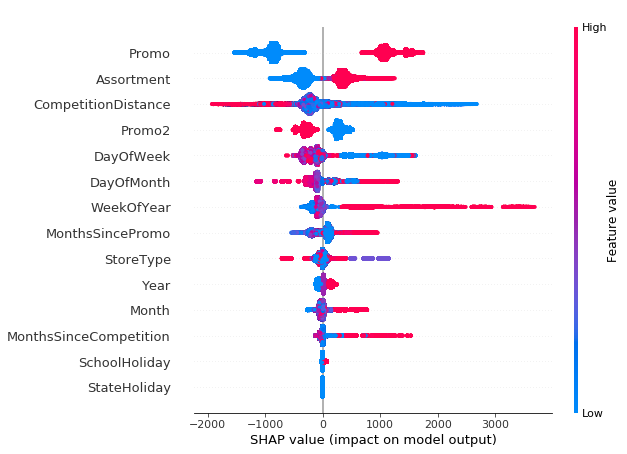

In [10]:
shap.summary_plot(shap_values, X)

### Explanation of individual predictions

In [11]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [12]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [13]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X.iloc[2,:])

### Explanation of the 100 firsts predictions (together)

In [17]:
shap.force_plot(explainer.expected_value, shap_values[:100], X[:100])